## Test case

In [2]:
import math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import pymc as pm
import arviz as az
from pymc.gp.util import plot_gp_dist

print(f"Running on PyMC v{pm.__version__}")
az.style.use("arviz-white")

RANDOM_SEED = 2023-10-10
rng = np.random.default_rng(RANDOM_SEED)

N_DRAWS = 1000
N_TUNE = 1000
N_PPC = 200 # No. prior predictive samples
N_NEW = 200 # No. posterior predictive samples

Running on PyMC v5.6.1


In [3]:
def plot_lc(filepath):
    """Plot light curve from raw CSV data including 1 sigma error bars"""
    
    this_lc = pd.read_csv(filepath)
    this_x = this_lc['mjd']
    this_y = this_lc['f_peak']
    this_yerr = this_lc['f_peak_err']
    mean_y = np.nanmean(this_y)

    plt.figure(figsize=(12, 5))
    plt.plot(this_x, this_y, "_b", ms=8, alpha=1, label="Observed data")
    plt.axhline(y=mean_y, c='blue', ls=':')
    plt.errorbar(x=this_x, y=this_y, yerr=this_yerr,
                 fmt="none", ecolor="k", elinewidth=1, capsize=3,
                 label=r"1 $\sigma$")
    plt.title(f"{filepath.stem} (N={len(this_y)})")
    plt.xlabel("Time")
    plt.ylabel("Flux")
    plt.legend()

In [4]:
csv_paths_list = list(Path('data_raw').iterdir())
csv_paths_list

[PosixPath('data_raw/80_ra271.352_dec-29.642_MAXIJ1803TraPDB_andersson.csv'),
 PosixPath('data_raw/1817_ra284.905_dec-8.658_J1858TraPDB_andersson.csv'),
 PosixPath('data_raw/428_ra236.530_dec-46.922_4U1543TraPDB_andersson.csv'),
 PosixPath('data_raw/502_ra236.310_dec-47.644_4U1543TraPDB_andersson.csv')]

# 428_ra236.530_dec-46.922_4U1543

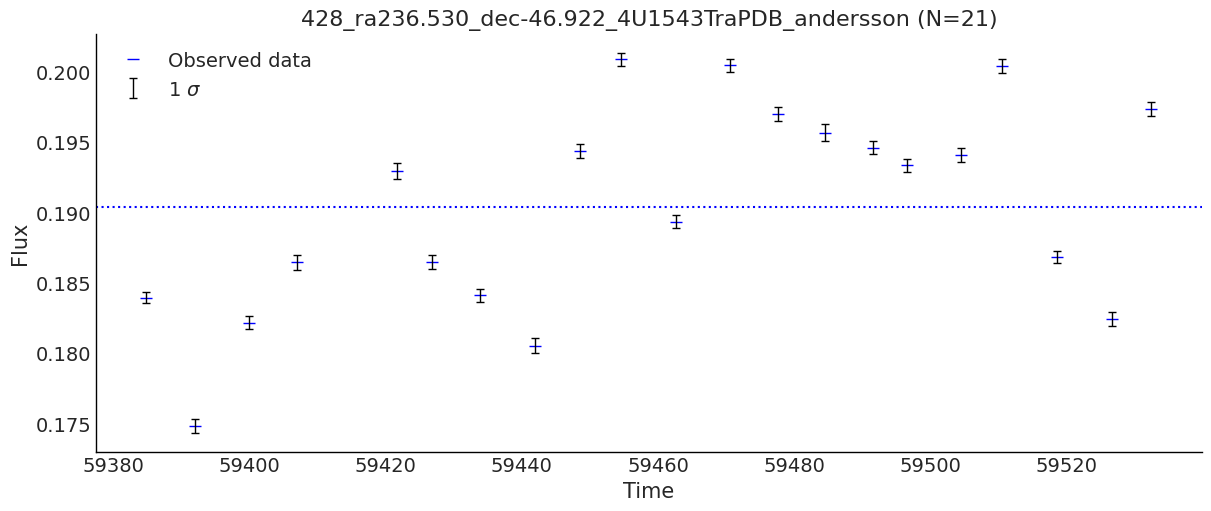

In [18]:
fpath = csv_paths_list[2]
plot_lc(fpath)

In [6]:
lc = pd.read_csv(fpath)

y = lc["f_peak"].to_numpy()
y_stderr = lc["f_peak_err"].to_numpy()
t = lc["mjd"].to_numpy()

N = t.shape[0]
y_min = np.nanmin(y)
y_max = np.nanmax(y)
y_mean = np.nanmean(y)
y_sd = np.nanstd(y)
y_range = np.ptp(y)
y_stderr_mean = np.nanmean(y_stderr)
y_stderr_sd = np.nanstd(y_stderr)
t_min = np.nanmin(t)
t_max = np.nanmax(t)
t_range = np.ptp(t)
t_mingap = np.diff(t).min()
t_maxgap = np.diff(t).max()

t = t - t_min # translate minimum to origin

{"N":N, "y_min":y_min, "y_max":y_max, "y_mean":y_mean, "y_sd":y_sd, "y_range":y_range, "y_stderr_mean":y_stderr_mean, "y_stderr_sd":y_stderr_sd, 
"t_min":t_min, "t_max":t_max, "t_range":t_range, "t_minGap":t_mingap, "t_maxGap":t_maxgap}

{'N': 21,
 'y_min': 0.174837825023698,
 'y_max': 0.200900812679486,
 'y_mean': 0.1903982656340805,
 'y_sd': 0.007211076120712034,
 'y_range': 0.026062987655788017,
 'y_stderr_mean': 0.0004906526416835524,
 'y_stderr_sd': 4.041657284245993e-05,
 't_min': 59384.88435070358,
 't_max': 59532.45253232262,
 't_range': 147.56818161904084,
 't_minGap': 4.999907674260612,
 't_maxGap': 14.682972612783487}

## SE Kernel only

$$Y \sim \mathcal{N}(f(t), \sigma_\textrm{WN}^2)$$

$$f(t) \sim \mathcal{MVN}(\boldsymbol{0}, k(\tau))$$

$$k(\tau) = \eta^2_\textrm{SE}\exp\left\{ - \frac{1}{2\ell_\textrm{SE}^2}\tau^2\right\}$$

$$\log 2\ell^2_\mathrm{SE} \sim \mathcal{U}[-15, 15]$$

$$\log \eta_\mathrm{SE} \sim \mathcal{U}[-15, 5]$$

$$\sigma_{i,\textrm{WN}} \sim \textrm{HalfNormal}(e_i^2)$$

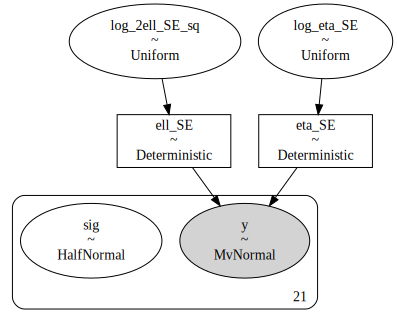

In [7]:
with pm.Model() as marginal_gp_model:
    log_2ell_SE_sq = pm.Uniform("log_2ell_SE_sq", lower=-10, upper=math.log(2*t_range**2))
    ell_SE = pm.Deterministic("ell_SE", 0.5*math.sqrt(2) * pm.math.exp(0.5*log_2ell_SE_sq))

    log_eta_SE= pm.Uniform("log_eta_SE", lower=-15, upper=5)
    eta_SE = pm.Deterministic("eta_SE", pm.math.exp(log_eta_SE))

    cov_func = eta_SE**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell_SE)
    
    gp = pm.gp.Marginal(cov_func=cov_func) # zero mean function 

    sig = pm.HalfNormal("sig", sigma=y_stderr) 
    cov_noise = pm.gp.cov.WhiteNoise(sigma=y_stderr)

    y_ = gp.marginal_likelihood(
        "y", 
        X=t.reshape(-1,1), 
        y=y.reshape(-1,1).flatten(), 
        sigma=cov_noise
    ) 

pm.model_to_graphviz(marginal_gp_model)

Sampling: [log_2ell_SE_sq, log_eta_SE, sig, y]


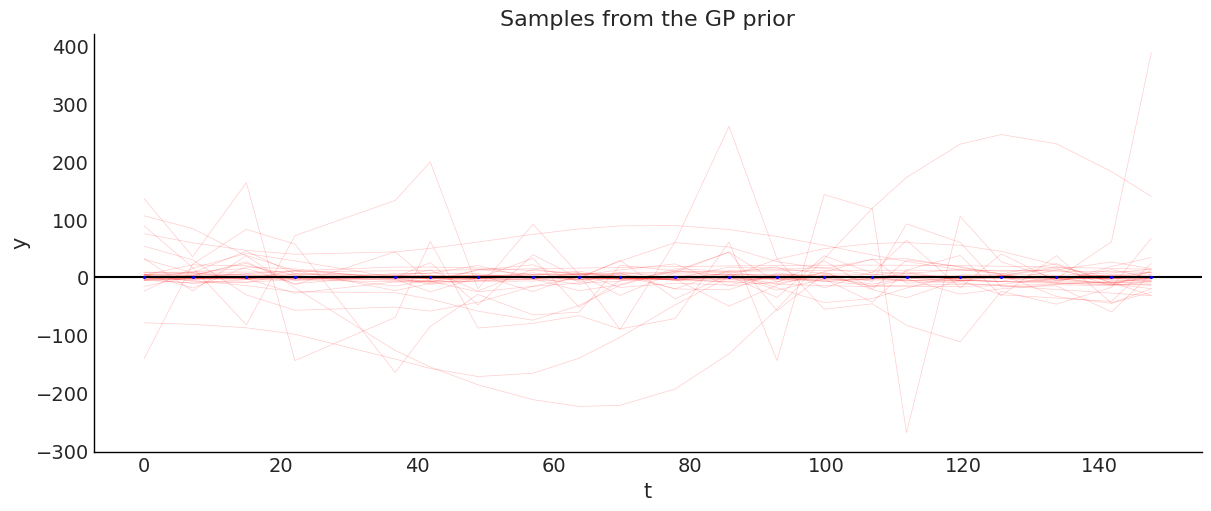

In [8]:
with marginal_gp_model:
    idata = pm.sample_prior_predictive(samples=N_PPC, random_seed=rng)
    
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,1,1)

for prior_pred in idata.prior_predictive.y.to_numpy()[0]:
    ax.plot(t, prior_pred, lw=0.5, alpha=0.2, color="red")

ax.scatter(x=t, y=y, s=1.5, c="blue", zorder=10)
ax.axhline(0, color="black")
ax.set_title("Samples from the GP prior")
ax.set_ylabel("y")
ax.set_xlabel("t");

In [9]:
with marginal_gp_model:
    idata.extend(
        pm.sample(
            draws=N_DRAWS, 
            tune=N_TUNE, 
            chains=4,
            cores=4, 
            random_seed=rng
        )       
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_2ell_SE_sq, log_eta_SE, sig]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.


In [10]:
variable_names = ["log_2ell_SE_sq", "log_eta_SE"]
az.summary(idata, stat_focus="median", fmt="wide", var_names=variable_names, round_to="none", kind="all")

,median,mad,eti_3%,eti_97%,mcse_median,ess_median,ess_tail,r_hat
log_2ell_SE_sq,5.706069,0.070757,5.483057,5.896594,0.001971,3435.024402,2857.820642,1.002410
log_eta_SE,-1.989372,0.130472,-2.313356,-1.559805,0.003507,3695.837619,2384.348100,1.002178


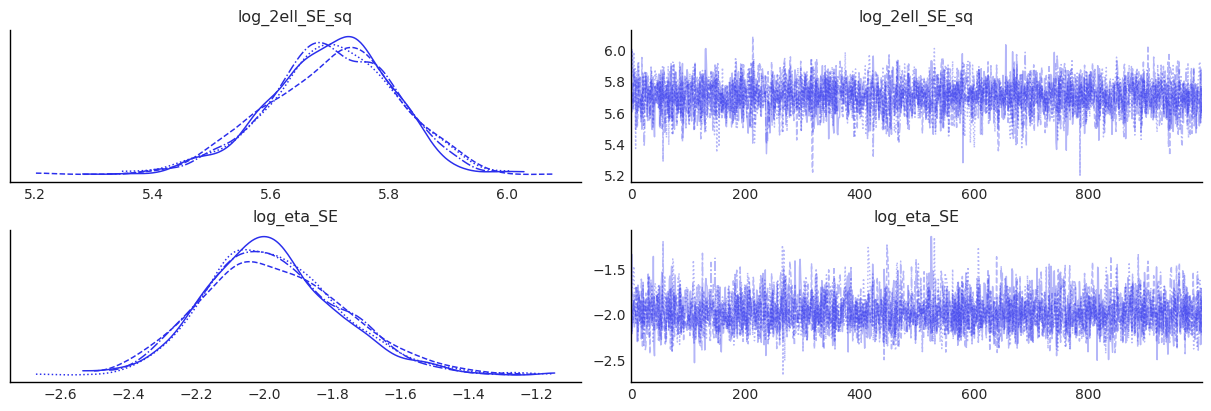

In [11]:
az.plot_trace(idata, var_names=variable_names, combined=False);

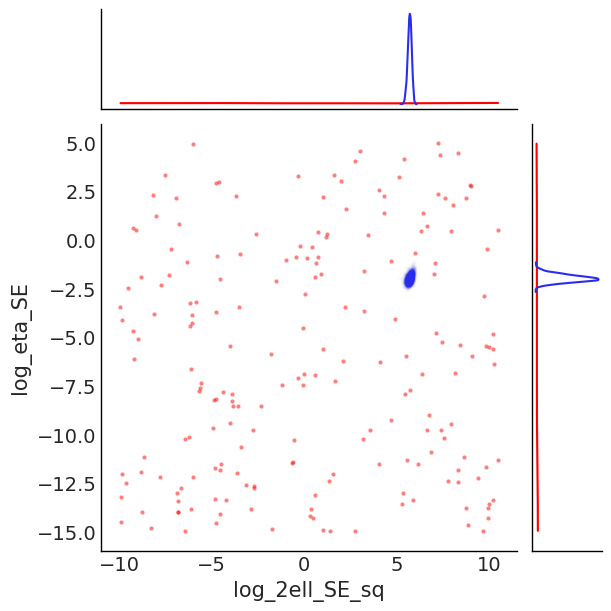

In [12]:
ax_list = az.plot_pair(
    idata, 
    group="prior", 
    var_names=variable_names,
    marginals=True, 
    figsize=(6,6), 
    kind=["scatter"],
    marginal_kwargs={"color":"red"},
    scatter_kwargs={"alpha":0.5, "color":"red"}
)

az.plot_pair(
    idata, 
    group="posterior",
    var_names=variable_names,
    marginals=True, 
    kind=["scatter"], 
    ax=ax_list, 
    scatter_kwargs={"alpha":0.01}
);

In [13]:
t_new = np.linspace(
    start=np.floor(t.min()), 
    stop=np.ceil(t.max()), 
    num = N_NEW
).reshape(-1,1)

with marginal_gp_model:
    f_star = gp.conditional(name="f_star", Xnew=t_new, jitter=1e-6, pred_noise=False) 

In [14]:
with marginal_gp_model:
    postpred_samples = pm.sample_posterior_predictive(
        idata.posterior,  
        var_names=["f_star"], 
        random_seed=rng
    )
    idata.extend(postpred_samples)

Sampling: [f_star]


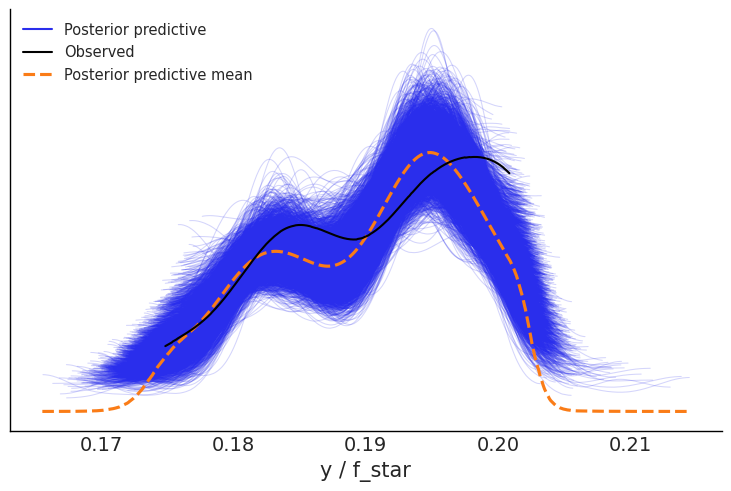

In [15]:
az.plot_ppc(postpred_samples, data_pairs={"y":"f_star"});

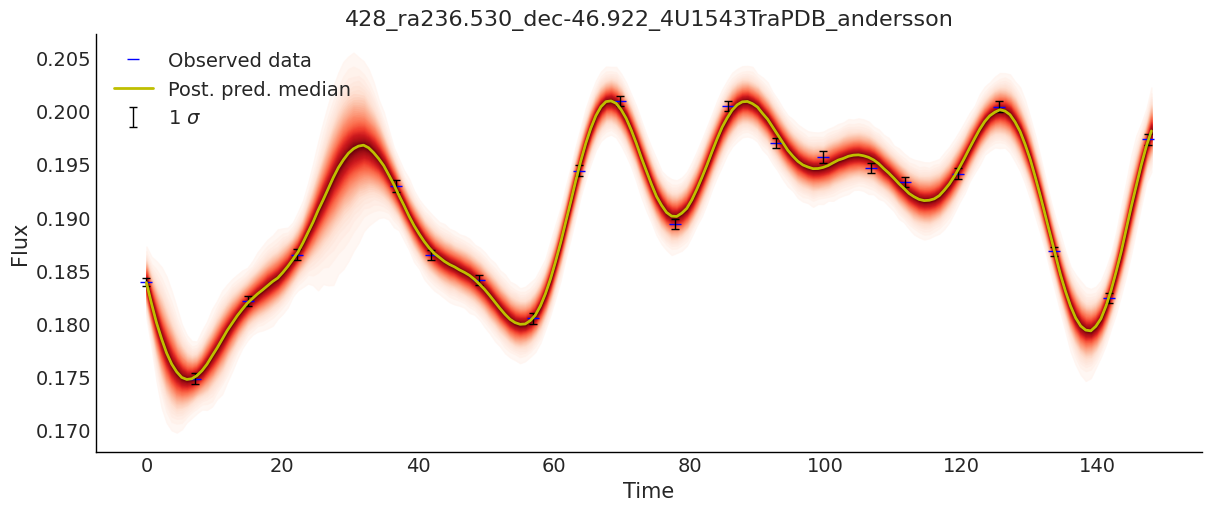

In [20]:
y_postpred = az.extract(postpred_samples.posterior_predictive, var_names=["f_star"])
y_postpred_median = y_postpred.median(dim="sample")

fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
plt.plot(t, y, "_b", ms=8, alpha=1, label="Observed data")
plt.errorbar(x=t, y=y, yerr=y_stderr, fmt="none", ecolor="k", elinewidth=1, capsize=3, label=r"1 $\sigma$")
plot_gp_dist(
    ax=ax, 
    samples=y_postpred.transpose("sample", ...),
    x=t_new,
    plot_samples=False
)
plt.plot(t_new.flatten(), y_postpred_median, "y", linewidth=2, label="Post. pred. median")
plt.title(f"{fpath.stem}")
plt.xlabel("Time")
plt.ylabel("Flux")
plt.legend();